In [11]:
# Install required libraries
!pip install lime shap scikit-learn numpy pandas matplotlib tensorflow pillow

# Note: After installation, restart the runtime to ensure all libraries are properly loaded.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=716a1a8983bfaa6d59312e4ca3314e5b3ec52f0f99d6e2eb2a947bfcd560519b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate, Input
from tensorflow.keras.applications import VGG16, ResNet152V2, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import cv2
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fernando2rad/x-ray-lung-diseases-images-9-classes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/x-ray-lung-diseases-images-9-classes


In [6]:
def preprocess_images(source_folder, target_folder, img_size=(256, 256)):
    categories = os.listdir(source_folder)
    for category in categories:
        img_paths = os.listdir(os.path.join(source_folder, category))
        os.makedirs(os.path.join(target_folder, category), exist_ok=True)
        for img_name in tqdm(img_paths, desc=f"Processing {category}"):
            img_path = os.path.join(source_folder, category, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, img_size)
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
            cv2.imwrite(os.path.join(target_folder, category, img_name), img_rgb)

def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(source_dir)
    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        train_val, test = train_test_split(images, test_size=1 - (train_ratio + val_ratio), random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)
        for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img in split_data:
                shutil.copy(os.path.join(class_path, img), os.path.join(split_class_dir, img))

In [7]:
def load_generators(size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    selected_classes = ['00 Anatomia Normal', '01 Processos Inflamatórios Pulmonares (Pneumonia)']

    train_generator = train_datagen.flow_from_directory(
        os.path.join(processed_output, 'train'),
        target_size=size,
        color_mode='rgb',
        classes=selected_classes,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True,
    )

    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(processed_output, 'val'),
        target_size=size,
        color_mode='rgb',
        classes=selected_classes,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False,
    )

    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(processed_output, 'test'),
        target_size=size,
        color_mode='rgb',
        classes=selected_classes,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False,
    )

    classes = train_generator.classes
    class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)
    class_weights = dict(enumerate(class_weights))

    return train_generator, val_generator, test_generator, class_weights

In [8]:
def build_hybrid_model(input_shape=(224, 224, 3)):
    input_tensor = Input(shape=input_shape, name="input_image")

    resnet_base = ResNet152V2(weights="imagenet", include_top=False, input_tensor=input_tensor)
    for layer in resnet_base.layers:
        layer._name = "resnet_" + layer.name
    resnet_output = GlobalAveragePooling2D()(resnet_base.output)

    # densenet_base = DenseNet201(weights="imagenet", include_top=False, input_tensor=input_tensor)
    # for layer in densenet_base.layers:
    #     layer._name = "densenet_" + layer.name
    # densenet_output = GlobalAveragePooling2D()(densenet_base.output)

    # merged = Concatenate()([resnet_output, densenet_output])
    merged = Concatenate()([resnet_output])
    output = Dense(1, activation="sigmoid")(merged)

    model = Model(inputs=input_tensor, outputs=output)
    return model

In [9]:
def evaluate_model(model, generator, dataset_name):
    y_true = generator.classes
    y_pred = model.predict(generator, verbose=1, steps=len(generator))
    y_pred_classes = np.round(y_pred).astype(int)

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(y_true, y_pred_classes, target_names=generator.class_indices.keys()))

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

    TP, TN = cm[1,1], cm[0,0]
    FP, FN = cm[0,1], cm[1,0]
    accuracy = (TP + TN) / np.sum(cm)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'Accuracy': accuracy * 100,
        'Precision': precision * 100,
        'Recall': recall * 100,
        'AUC': roc_auc * 100
    }

Processing 04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia): 100%|██████████| 644/644 [00:01<00:00, 462.58it/s]
Processing 02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema): 100%|██████████| 678/678 [00:01<00:00, 357.39it/s]
Processing 03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio): 100%|██████████| 629/629 [00:01<00:00, 353.45it/s]
Processing 08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias): 100%|██████████| 544/544 [00:01<00:00, 275.58it/s]
Processing 06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases): 100%|██████████| 658/658 [00:02<00:00, 261.90it/s]
Processing 05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose): 100%|██████████| 594/594 [00:02<00:00, 273.42it/s]
Processing 00 Anatomia Normal: 100%|██████████| 1340/1340 [00:05<00:00, 252.01it/s]
Processing 07 Alterações de Mediastino (Pericardite, Malfo

Found 1678 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8551 - auc: 0.9207 - loss: 0.3501 - precision: 0.8213 - recall: 0.8481 - val_accuracy: 0.9167 - val_auc: 0.9672 - val_loss: 0.2711 - val_precision: 0.9574 - val_recall: 0.8491 - learning_rate: 1.0000e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 695ms/step - accuracy: 0.9534 - auc: 0.9920 - loss: 0.1201 - precision: 0.9461 - recall: 0.9464 - val_accuracy: 0.7500 - val_auc: 0.9558 - val_loss: 0.7517 - val_precision: 0.6386 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 940ms/step - accuracy: 0.9621 - auc: 0.9917 - loss: 0.1096 - precision: 0.9518 - recall: 0.9618 - val_accuracy: 0.9389 - val_auc: 0.9903 - val_loss: 0.1877 - val_precision: 0.8870 - val_recall: 0.9874 - learning_rate: 1.0000e-04
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 69s 695ms/step - accuracy: 0.9695 - auc: 0.9946 - loss: 0.0865 - precision: 0.9521 - recall: 0.9789 - val_accuracy: 0.9083 - val_auc: 0.9877 - val_loss

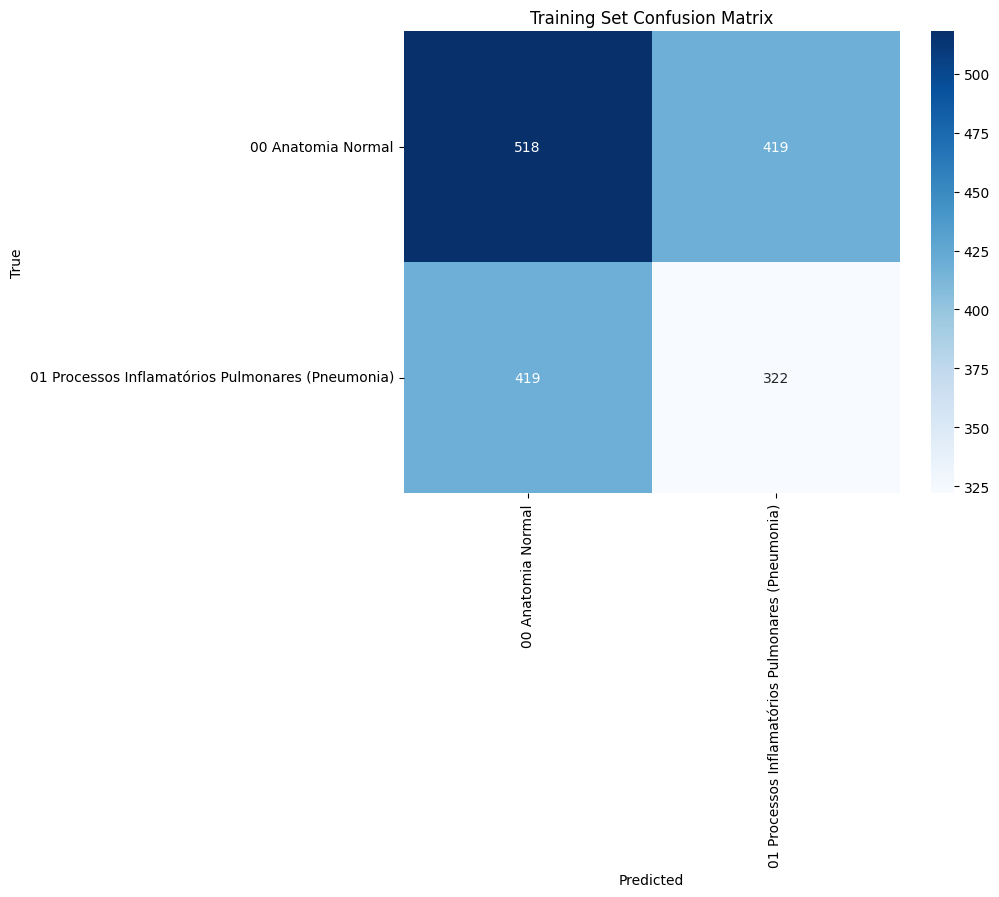


Classification Report for Training Set:
                                                   precision    recall  f1-score   support

                               00 Anatomia Normal       0.55      0.55      0.55       937
01 Processos Inflamatórios Pulmonares (Pneumonia)       0.43      0.43      0.43       741

                                         accuracy                           0.50      1678
                                        macro avg       0.49      0.49      0.49      1678
                                     weighted avg       0.50      0.50      0.50      1678



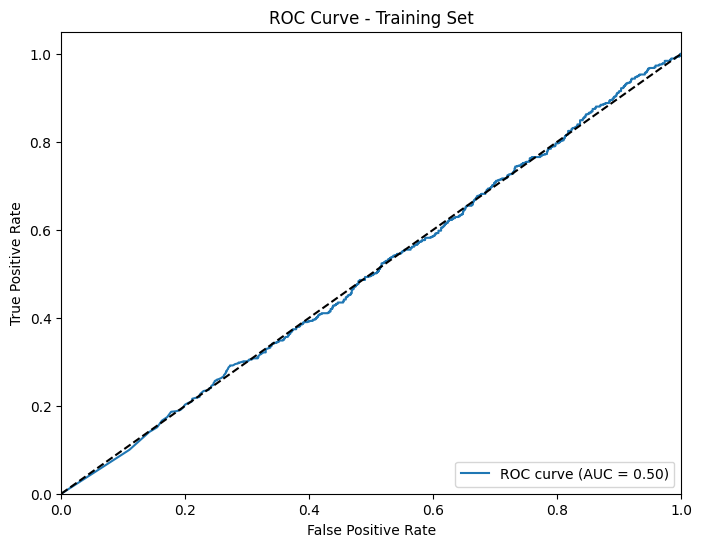

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 426ms/step


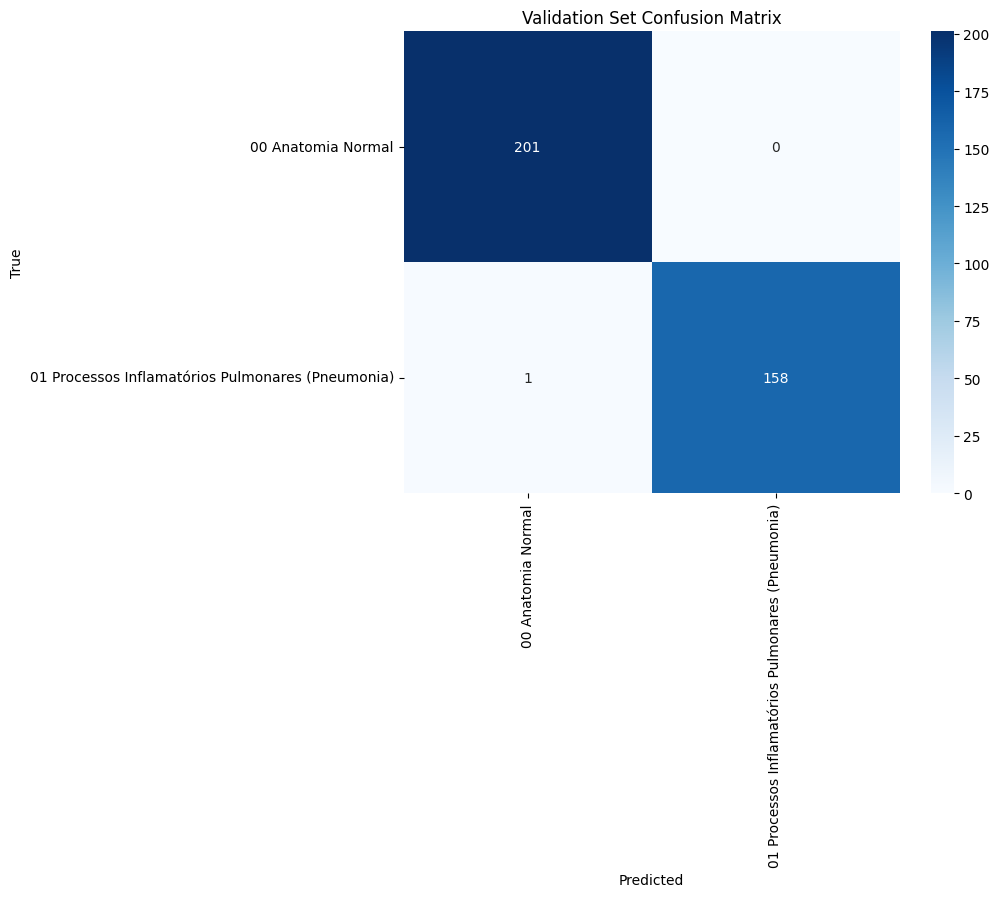


Classification Report for Validation Set:
                                                   precision    recall  f1-score   support

                               00 Anatomia Normal       1.00      1.00      1.00       201
01 Processos Inflamatórios Pulmonares (Pneumonia)       1.00      0.99      1.00       159

                                         accuracy                           1.00       360
                                        macro avg       1.00      1.00      1.00       360
                                     weighted avg       1.00      1.00      1.00       360



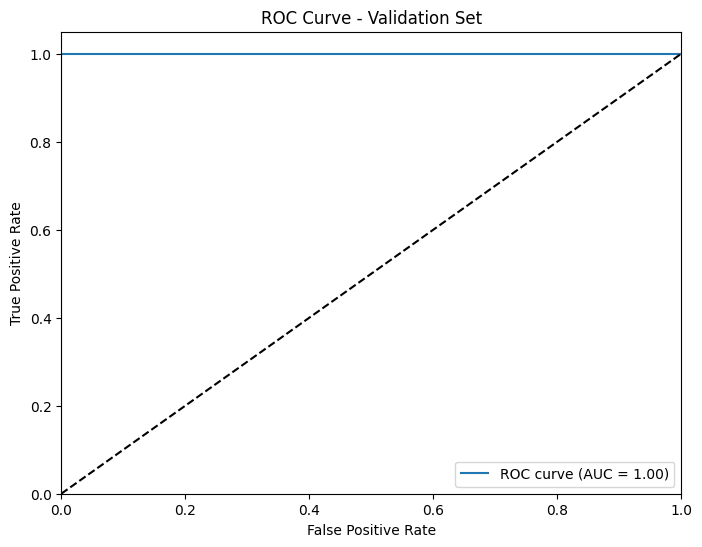

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 607ms/step


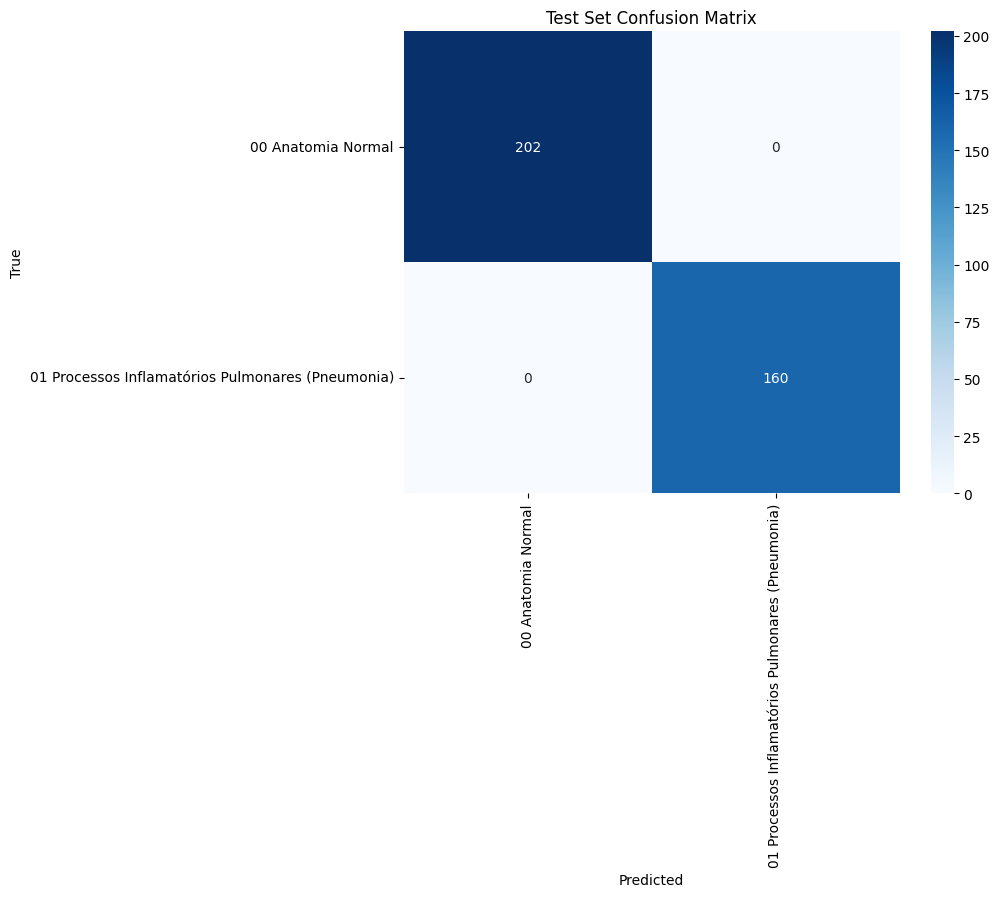


Classification Report for Test Set:
                                                   precision    recall  f1-score   support

                               00 Anatomia Normal       1.00      1.00      1.00       202
01 Processos Inflamatórios Pulmonares (Pneumonia)       1.00      1.00      1.00       160

                                         accuracy                           1.00       362
                                        macro avg       1.00      1.00      1.00       362
                                     weighted avg       1.00      1.00      1.00       362



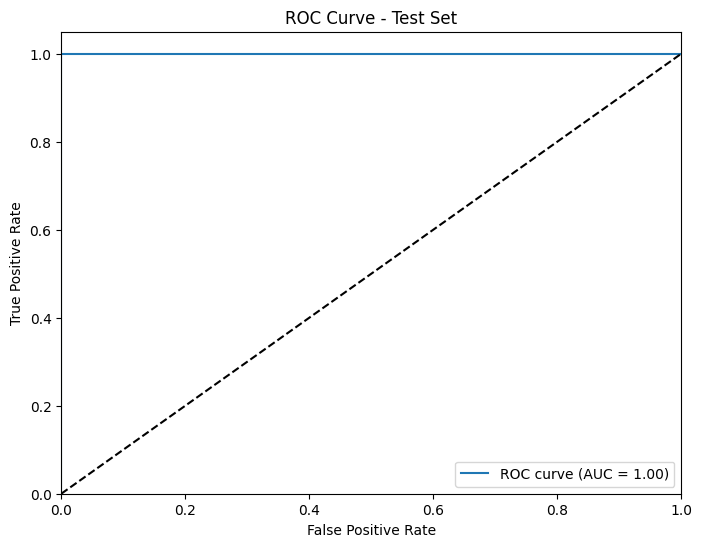


Final Performance Metrics:
      Dataset    Accuracy   Precision      Recall         AUC   TP   TN   FP  \
0    Training   50.059595   43.454791   43.454791   49.992655  322  518  419   
1  Validation   99.722222  100.000000   99.371069  100.000000  158  201    0   
2        Test  100.000000  100.000000  100.000000  100.000000  160  202    0   

    FN  
0  419  
1    1  
2    0  


In [10]:
if __name__ == "__main__":
    source_dir = '/kaggle/input/x-ray-lung-diseases-images-9-classes'
    target_dir = '/kaggle/processed/x-ray-lung-diseases-images'
    processed_output = '/kaggle/working/xray_split'

    preprocess_images(source_dir, target_dir)
    split_dataset(target_dir, processed_output)

    train_gen, val_gen, test_gen, class_weights = load_generators()

    model = build_hybrid_model()
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
        ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_auc', mode='max'),
        TensorBoard(log_dir='./logs')
    ]

    history = model.fit(
        train_gen,
        epochs=30,
        validation_data=val_gen,
        class_weight=class_weights,
        callbacks=callbacks,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen)
    )

    model.save('your_model_name.keras', overwrite=True)

    train_results = evaluate_model(model, train_gen, 'Training Set')
    val_results = evaluate_model(model, val_gen, 'Validation Set')
    test_results = evaluate_model(model, test_gen, 'Test Set')

    results_df = pd.DataFrame({
        'Dataset': ['Training', 'Validation', 'Test'],
        'Accuracy': [train_results['Accuracy'], val_results['Accuracy'], test_results['Accuracy']],
        'Precision': [train_results['Precision'], val_results['Precision'], test_results['Precision']],
        'Recall': [train_results['Recall'], val_results['Recall'], test_results['Recall']],
        'AUC': [train_results['AUC'], val_results['AUC'], test_results['AUC']],
        'TP': [train_results['TP'], val_results['TP'], test_results['TP']],
        'TN': [train_results['TN'], val_results['TN'], test_results['TN']],
        'FP': [train_results['FP'], val_results['FP'], test_results['FP']],
        'FN': [train_results['FN'], val_results['FN'], test_results['FN']]
    })

    print("\nFinal Performance Metrics:")
    print(results_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

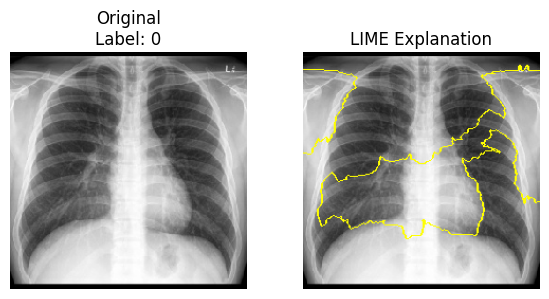

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

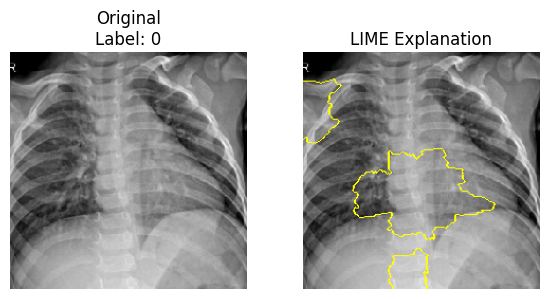

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

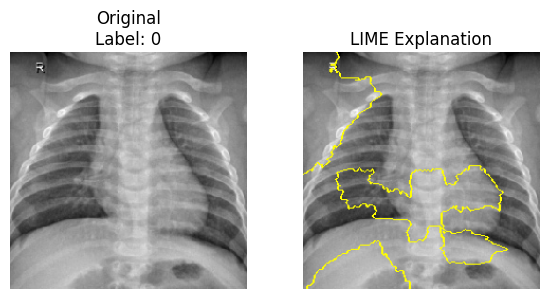

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

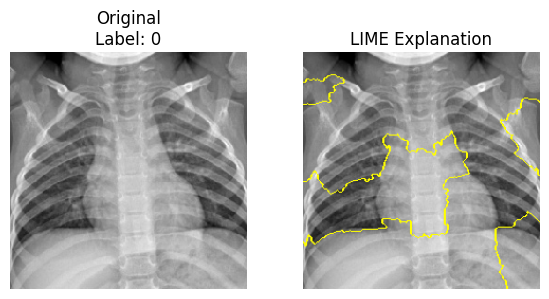

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

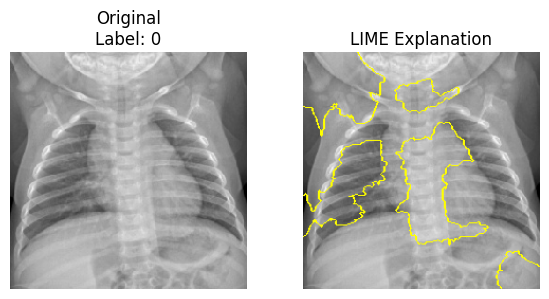

In [12]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def lime_predict(images):
    images = images / 255.0
    preds = model.predict(images)
    return np.concatenate([1 - preds, preds], axis=1)

x_test, y_test = next(test_gen)

explainer = lime_image.LimeImageExplainer()

for i in range(5):
    image = x_test[i]
    label = y_test[i]

    explanation = explainer.explain_instance(
        image.astype('double'),
        lime_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original\nLabel: {int(label)}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME Explanation")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
